CIFAR-10 label mapping:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship
9: truck


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

In [2]:
latent_dim = 100
batch_size = 32
epochs = 10
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
TARGET_CLASS = 0  # Airplane

In [3]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# Flatten labels
y_train = y_train.flatten()

# Filter only the target class
x_train = x_train[y_train == TARGET_CLASS]
x_train.shape

(5000, 32, 32, 3)

In [4]:
# Normalize images to [0, 255] → [-1, 1]
# tanh() outputs values in: [-1 , +1], if real images are in [0,1] but fake images in [-1,1]:
# Discriminator instantly detects fake images and GAN collapses

x_train = (x_train.astype(np.float32) - 127.5) / 127.5


In [5]:
dataset = tf.data.Dataset.from_tensor_slices(x_train) # Converts NumPy array into a TensorFlow Dataset object
dataset = dataset.shuffle(buffer_size=60000).batch(batch_size, drop_remainder=True) # Buffer size ≥ dataset size (50,000) -> perfect shuffle

In [6]:
for item in dataset:
  print(item.shape)
  break

(32, 32, 32, 3)


In [7]:
## 5. Generator Model (Keras)

In [8]:
def build_generator():
    model = tf.keras.Sequential(name="Simple_Generator")

    # Noise → feature vector
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.ReLU())

    # Project to low-resolution image
    model.add(layers.Dense(8 * 8 * 64)) # Expands vector to 8 × 8 × 64 neurons
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 64))) # Converts flat vector → 3D tensor

    # Upsample to 16×16
    model.add(layers.UpSampling2D()) # Doubles spatial resolution: 8×8 → 16×16
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample to 32×32
    model.add(layers.UpSampling2D()) #
    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh")) # Generator output range must match real data range

    return model
    # The simplified generator transforms a random noise vector into a low-resolution feature map and
    # progressively upsamples it using convolutional layers to generate a 32×32 RGB image.


In [9]:
# The simplified generator transforms a random noise vector into a low-resolution feature map and
# progressively upsamples it using convolutional layers to generate a 32×32 RGB image.

def build_generator():
    model = tf.keras.Sequential(name="Simple_Generator")

    # Noise → feature vector
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.ReLU())

    # Project to low-resolution image
    model.add(layers.Dense(8 * 8 * 64)) # Expands vector to 8 × 8 × 64 neurons
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((8, 8, 64))) # Converts flat vector → 3D tensor

    # Upsample to 16×16
    model.add(layers.UpSampling2D()) # Doubles spatial resolution: 8×8 → 16×16
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Upsample to 32×32
    model.add(layers.UpSampling2D()) # Double spatial resolution: 16×16 → 32×32
    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh")) # Generator output range must match real data range

    return model




In [10]:
generator = build_generator()
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Simple_Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 3)      │         1,731 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,187 (4.26 MB)

 Trainable params: 1,117,187 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def build_discriminator():
    model = tf.keras.Sequential(name="Simple_Discriminator")

    # Input: 32×32×3 image
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(32, 32, 3))) # Input  : (32, 32, 3) - > Output : (16, 16, 32)
    model.add(layers.LeakyReLU(0.2)) # Discriminators should never fully suppress gradients.

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same")) # Input  : (16, 16, 32) -> Output : (8, 8, 64)
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten()) # Converts feature map into a 1D vector (8, 8, 64) → (4096,)
    model.add(layers.Dense(1, activation="sigmoid"))

    return model


In [12]:
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Simple_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,489 (91.75 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
##  Loss Function & Optimizers

In [14]:
loss_fn = losses.BinaryCrossentropy()


In [15]:
optimizer_G = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
optimizer_D = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)


In [16]:
## 8. Training Step Functions

In [17]:
## Train Discriminator

In [18]:
@tf.function # Converts the Python function into a TensorFlow computation graph
def train_discriminator(real_images): # real_images → (batch_size, 32, 32, 3)
    noise = tf.random.normal([batch_size, latent_dim]) # Samples random noise from a standard normal distribution - > (batch_size, latent_dim)

    with tf.GradientTape() as tape: # Records all operations inside this block and Enables automatic differentiation

        fake_images = generator(noise, training=True) # fake_images → (batch_size, 32, 32, 3)

        real_preds = discriminator(real_images, training=True) # training=True ensures:BatchNorm behaves correctly and Dropout (if any) is active
        fake_preds = discriminator(fake_images, training=True)

        # real_loss = loss_fn(tf.ones_like(real_preds), real_preds)
        real_loss = loss_fn(tf.ones_like(real_preds) * 0.9, real_preds) # Reduce discriminator confidence (label smoothing)
                                                                        # Prevents discriminator from overpowering generator.
        fake_loss = loss_fn(tf.zeros_like(fake_preds), fake_preds)

        d_loss = (real_loss + fake_loss) / 2

    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer_D.apply_gradients(zip(grads, discriminator.trainable_variables))

    return d_loss


In [19]:
## Train Generator

In [20]:
@tf.function
def train_generator():
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        preds = discriminator(fake_images, training=True)

        g_loss = loss_fn(tf.ones_like(preds), preds)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(grads, generator.trainable_variables))

    return g_loss


In [21]:
## 9. Training Loop

Epoch 1/10 | Step 0 | D Loss: 0.6925 | G Loss: 0.6850
Epoch 2/10 | Step 0 | D Loss: 0.7349 | G Loss: 0.9596
Epoch 3/10 | Step 0 | D Loss: 0.7971 | G Loss: 0.6815
Epoch 4/10 | Step 0 | D Loss: 0.6150 | G Loss: 0.8999
Epoch 5/10 | Step 0 | D Loss: 0.5546 | G Loss: 1.2882
Epoch 6/10 | Step 0 | D Loss: 0.6982 | G Loss: 0.8791
Epoch 7/10 | Step 0 | D Loss: 0.7141 | G Loss: 0.8228
Epoch 8/10 | Step 0 | D Loss: 0.7111 | G Loss: 0.8933
Epoch 9/10 | Step 0 | D Loss: 0.7375 | G Loss: 0.7225
Epoch 10/10 | Step 0 | D Loss: 0.6268 | G Loss: 1.3245

📸 Visualizing generated images at Epoch 10



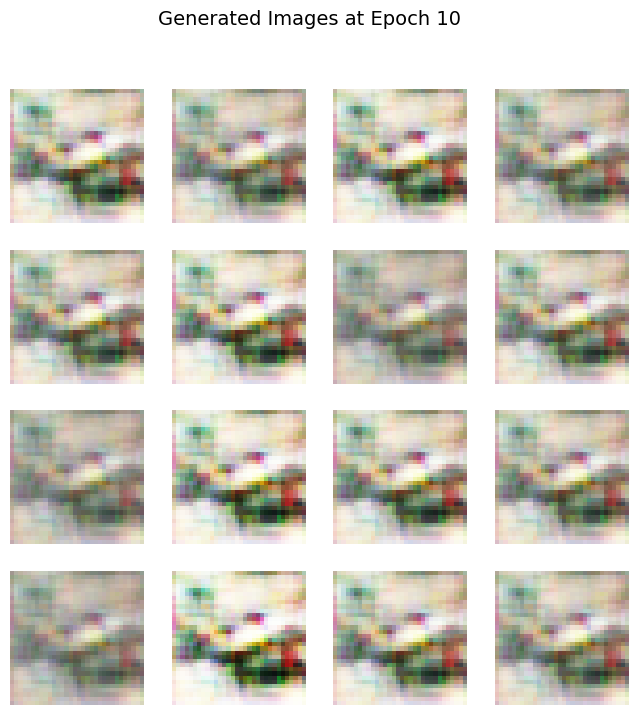

In [22]:
# 🔒 Fixed noise (define ONCE)
fixed_noise = tf.random.normal([16, latent_dim])
for epoch in range(epochs):
    for step, real_images in enumerate(dataset):

        d_loss = train_discriminator(real_images)
        # d_loss = train_discriminator(real_images)  # train Discriminator twice
        g_loss = train_generator()

        if step % 200 == 0:
            print(
                f"Epoch {epoch+1}/{epochs} | Step {step} | "
                f"D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}"
            )

    # Visualization after 10 epoch
    if (epoch + 1) % 10 == 0:
      print(f"\n📸 Visualizing generated images at Epoch {epoch+1}\n")
      # noise = tf.random.normal([16, latent_dim])
      gen_imgs = generator(fixed_noise, training=False)
      gen_imgs = (gen_imgs + 1) / 2  # [-1,1] → [0,1]
      gen_imgs = tf.clip_by_value(gen_imgs, 0.0, 1.0)
      gen_imgs = gen_imgs.numpy()

      fig, axs = plt.subplots(4, 4, figsize=(8,8))
      cnt = 0
      for i in range(4):
        for j in range(4):
          axs[i, j].imshow(gen_imgs[cnt])
          axs[i, j].axis("off")
          cnt += 1
      plt.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=14)
      plt.show()
